# **Original publication: "A single-cell and spatially resolved atlas of human breast cancers"**

Preprocess of the data from Wu et al., to obtain log-normalized counts for further applications.  

In [3]:
global_path = './cell-cell-communication/' ## Path to the github downloaded repository

## Import packages

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors

## Build anndata object and load metadata

In [5]:
data_path = global_path + 'Data/Breast/Wu_etal_2021_BRCA_scRNASeq/'

## Build adata object 
adata = sc.read_10x_mtx(
    data_path,  # the directory with the `.mtx` file, genes and barcodes
    var_names='gene_symbols', # use gene symbols for the variable names 
    cache=True) 

adata.var_names_make_unique()  # Make variable names unique

metadata = pd.read_csv(data_path + 'Whole_miniatlas_meta.csv', sep=',', dtype=str)
metadata = metadata.drop(metadata.index[0])

## Add metadata to the anndata object
adata.obs['Patient'] = list(metadata['Patient'])
adata.obs['subtype'] = list(metadata['subtype'])
adata.obs['celltype_major'] = list(metadata['celltype_major'])
adata.obs['celltype_minor'] = list(metadata['celltype_minor'])
adata.obs['celltype_subset'] = list(metadata['celltype_subset'])

## Add metadata related to the patients 
metadata_patients = pd.read_csv(data_path + "meta_patients.csv", sep=",", dtype=str)
metadata_patients.columns = ['Patient','Grade','Cancer Type','Treatment status']
adata.obs = pd.merge(adata.obs.reset_index(), metadata_patients, on='Patient').set_index('index')

del(metadata, metadata_patients)


NB: to be able to use this package we need the matrices in called: matrix.mtx, genes.tsv and barcodes.tsv. You can indicate a prefix (as an argument) but not a sufix 

Also you need two columns in genes.tsv --> ensemblid and gene symbol


In [5]:
### Check point: Make sure that the data is not normalized
adata.X.toarray().max()

29831.0

## Exploration of the metadata

We begin by examining the data's characteristics. We look at the number of cells / patient by condition: different subtypes of breast cancer, which can be further categorized by histological type and treatment status. 

### Number of cells per BC subtype

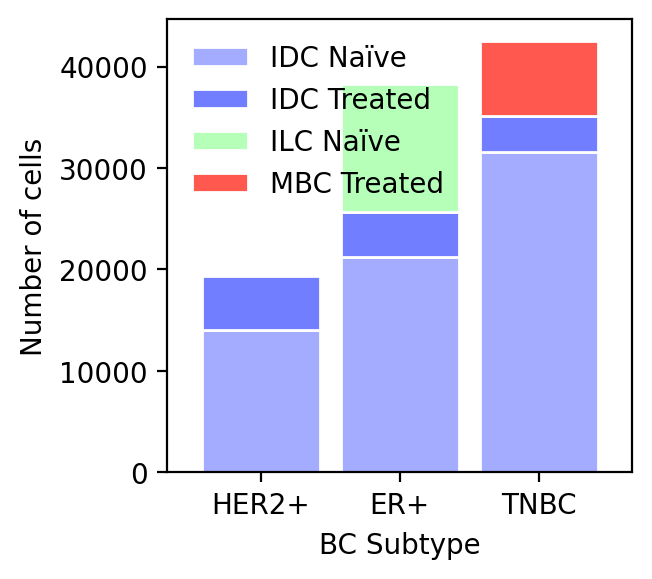

In [6]:
plot_df = adata.obs.groupby(['subtype', 'Cancer Type', 'Treatment status']).size().reset_index(name='count')

pivot_table = plot_df.pivot_table(index='subtype', 
                                  columns=['Cancer Type', 'Treatment status'], 
                                  values='count', 
                                  fill_value=0)
                                  
pivot_table = pivot_table.sort_values(by =('IDC',   'Naïve')) # To order the plot 

colormap = ["#a3acff", '#707eff','#b5ffb9', '#ff594f']
barWidth = 0.85

fig, ax= plt.subplots(1, figsize=(3, 3), dpi = 200)
pivot_table.plot(kind='bar', stacked=True, ax = ax, color = colormap, edgecolor='white', width=barWidth)
ax.set_xticklabels(ax.get_xticklabels(), rotation =0)
ax.set_xlabel('BC Subtype')
ax.set_ylabel('Number of cells')

handles, labels = ax.get_legend_handles_labels()
new_labels = ['IDC Naïve', 'IDC Treated', 'ILC Naïve', 'MBC Treated']
legend = ax.legend(handles, new_labels, frameon = False)

### Number of patients per breast cancer subtype

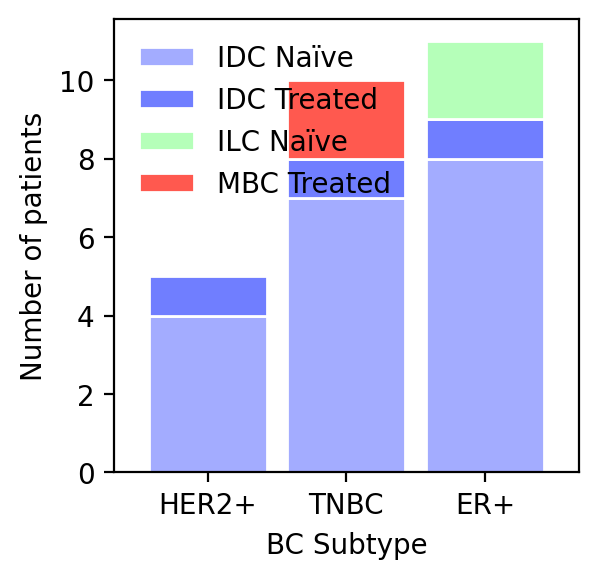

In [7]:
patient_plot_df = adata.obs.groupby(['subtype', 'Cancer Type', 'Treatment status'])['Patient'].nunique().reset_index(name = 'count')

pivot_table_patient = patient_plot_df.pivot_table(index='subtype', 
                                  columns=['Cancer Type', 'Treatment status'], 
                                  values='count', 
                                  fill_value=0)
                                  
pivot_table_patient = pivot_table_patient.sort_values(by =('IDC',   'Naïve')) # To order the plot 

colormap = ["#a3acff", '#707eff','#b5ffb9', '#ff594f']
barWidth = 0.85

fig, ax= plt.subplots(1, figsize=(3, 3), dpi = 200)
pivot_table_patient.plot(kind='bar', stacked=True, ax = ax, color = colormap, edgecolor='white', width=barWidth)
ax.set_xticklabels(ax.get_xticklabels(), rotation =0)
ax.set_xlabel('BC Subtype')
ax.set_ylabel('Number of patients')

handles, labels = ax.get_legend_handles_labels()
new_labels = ['IDC Naïve', 'IDC Treated', 'ILC Naïve', 'MBC Treated']
legend = ax.legend(handles, new_labels, frameon = False, loc = 'upper left')

## Preprocessing and visualization

We followed the Scanpy tutorial and recommendations to process the data. 

### **Quality Control**

Explore mitochondrial genes, which in high proportions are indicative of poor-quality cells.  

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['log_counts'] = np.log(adata.obs['total_counts'])


`calculate_qc_metrics` compute the main metrics for QC: 
- n_gene_by_counts --> genes for which we have a value higher that 0
- total_counts 
- pct_counts_mt --> percentage of the total counts that corresponds to mitocondrial genes

We represent these metrics by patient using violin plots (patient colored w/ same color are from the same subtype)

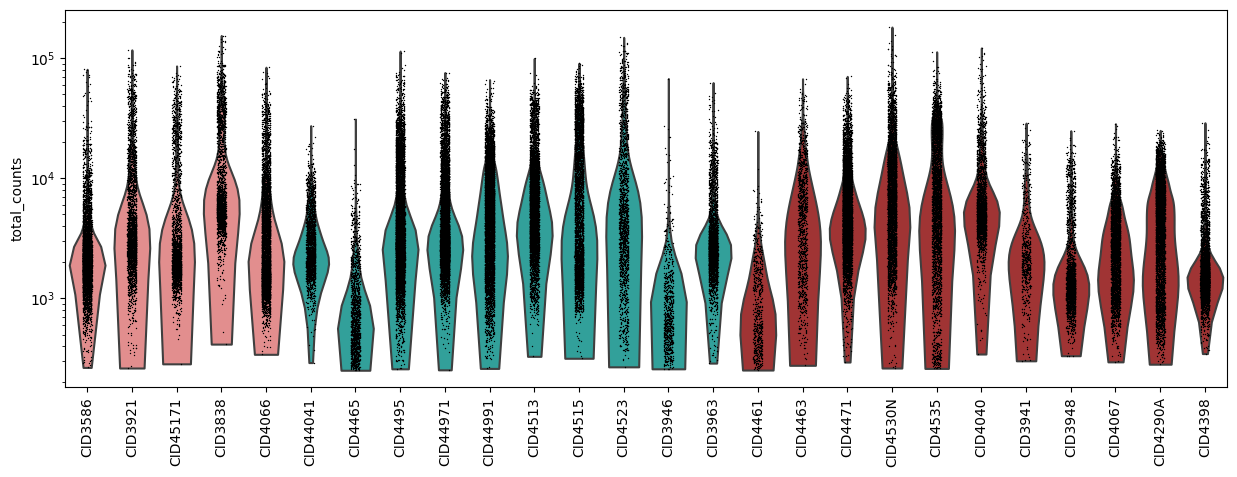

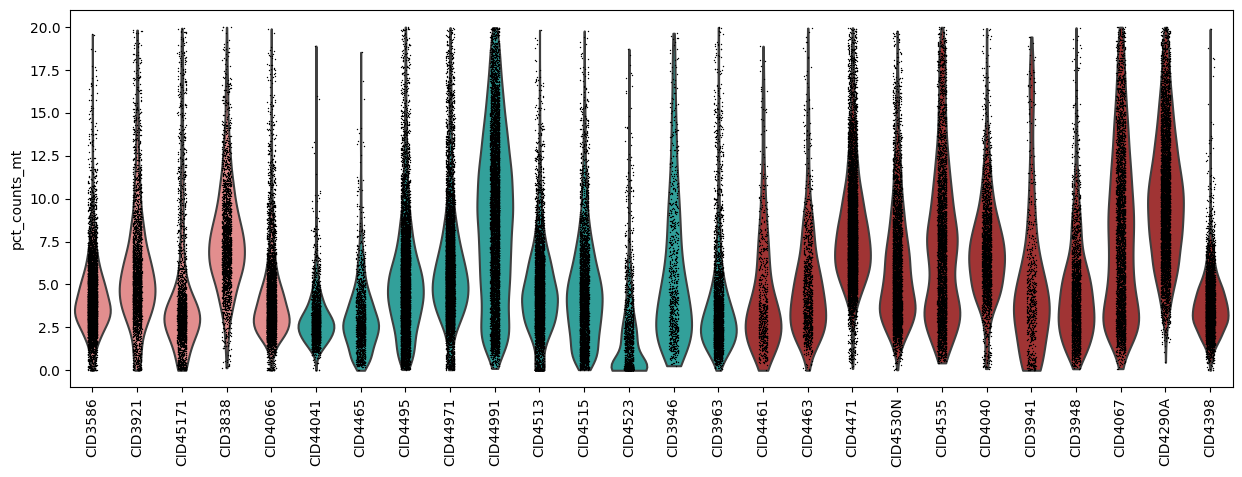

In [9]:
patients = list(adata.obs[['Patient','subtype']].drop_duplicates().Patient.values)
subtypes = list(adata.obs[['Patient','subtype']].drop_duplicates().subtype.values)
color = []
for i in subtypes: 
    if i == 'HER2+': 
        color.append('lightcoral')
    elif i == 'TNBC':
        color.append('lightseagreen')
    else: 
        color.append('firebrick')

kwargs = {'palette':color}

fig, axes = plt.subplots(1, 1, figsize=(15,5), dpi = 100)
t1 = sc.pl.violin(adata, 'total_counts', groupby='Patient', size=1, log=True, cut=0, ax = axes, rotation = 90, order=patients, **kwargs)
fig, axes = plt.subplots(1, 1, figsize=(15,5), dpi = 100)
t2 = sc.pl.violin(adata, 'pct_counts_mt', groupby='Patient', ax = axes, rotation = 90,order=patients, **kwargs)

We can see some differences in the distribution of mitocondrial counts and UMI counts between the patiens. However, in principle all of them have good distributions. Moreover data was already filtered by the original authors. 

### **Normalization**

Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling.

Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [10]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()
# Normalization and log transformation
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

# adata.write('Data/Breast/normalized_log.h5ad')  

NB: For the majority of the downstream analysis we started from this adata, with all the genes and without scaling 

### **Highly Variable Genes**

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes.

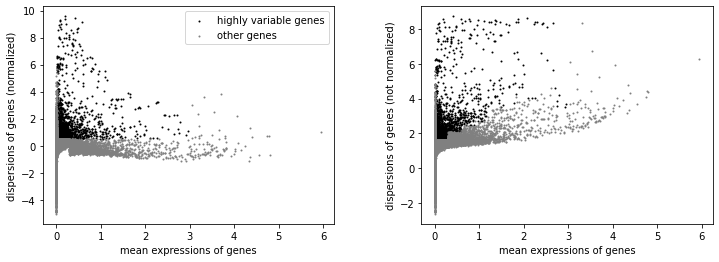

In [11]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)


In [12]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"]) # to correct for differences in sequencing depth and mitochondrial genes expressed
sc.pp.scale(adata, max_value=10)


### **Dimensionality reduction**

#### PCA

PCA reveals the main axes of variation and denoises the data. We are going to calculate 100 components (original paper)

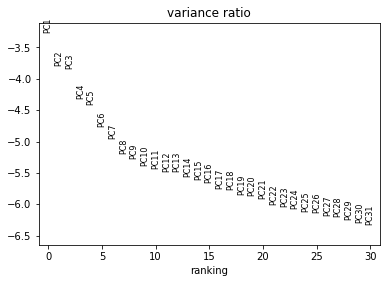

In [13]:
sc.tl.pca(adata, n_comps = 100)
sc.pl.pca_variance_ratio(adata, log=True) # This gives us information about how many PCs we should use for the clustering

### **Visualization (UMAP)**

In [14]:
sc.pp.neighbors(adata, n_pcs = 40,  n_neighbors=10) # Compute the neighborhood graph of cells
sc.tl.umap(adata)

/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/

### **Clustering**

In [15]:
sc.tl.leiden(adata)

/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data f

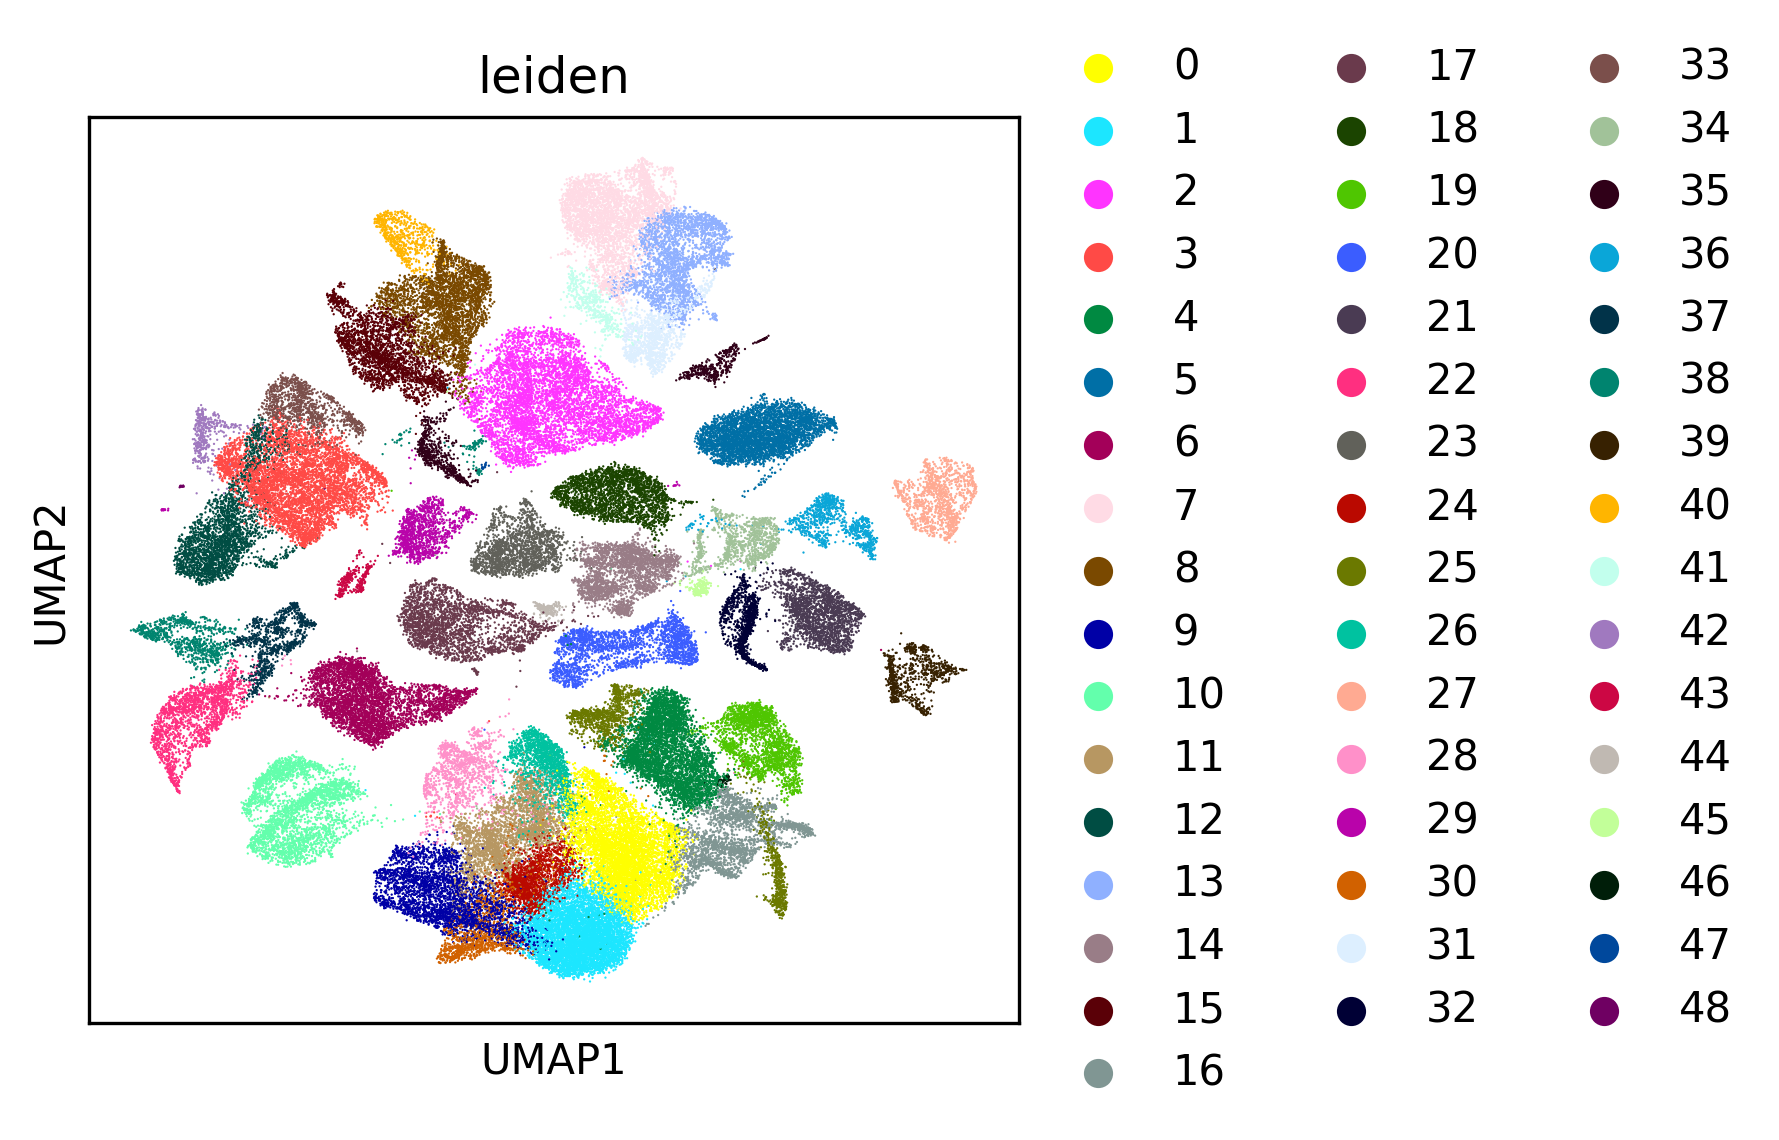

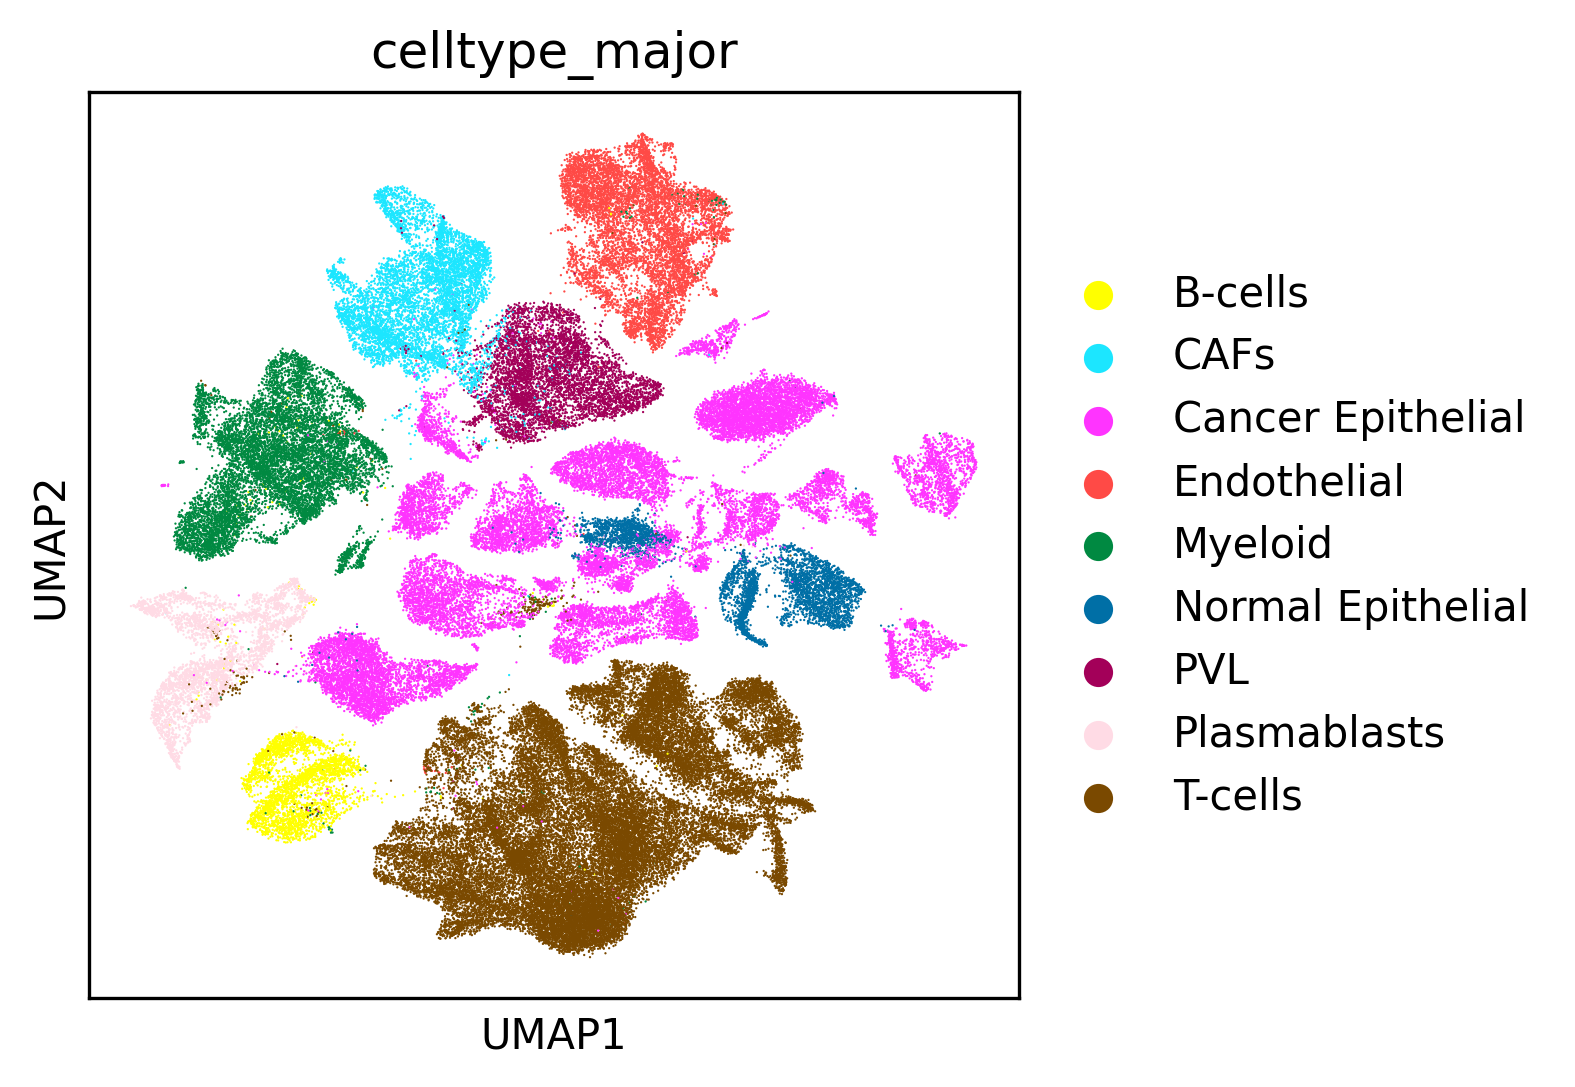

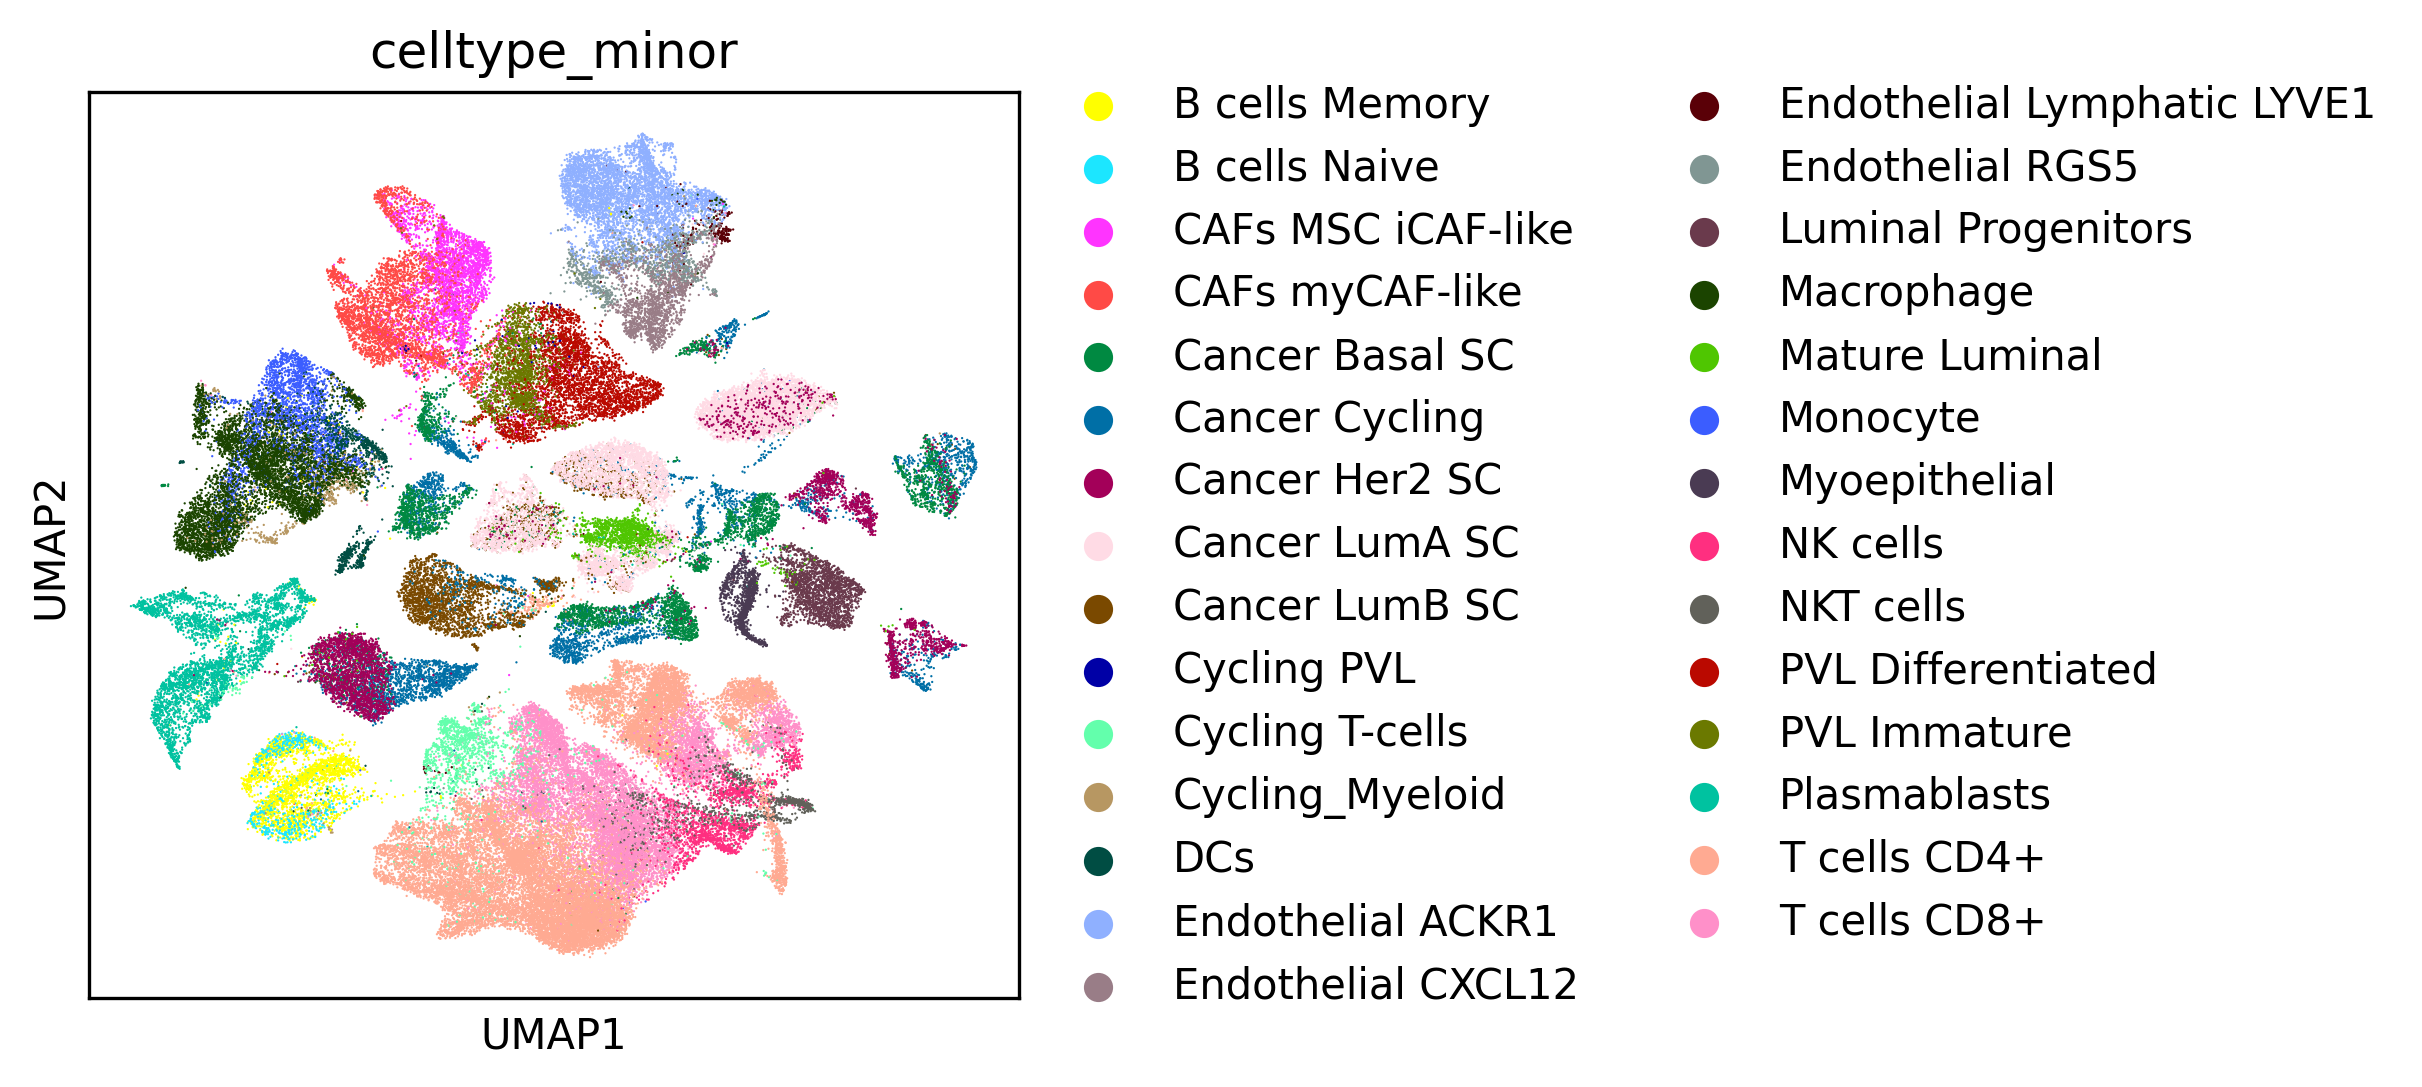

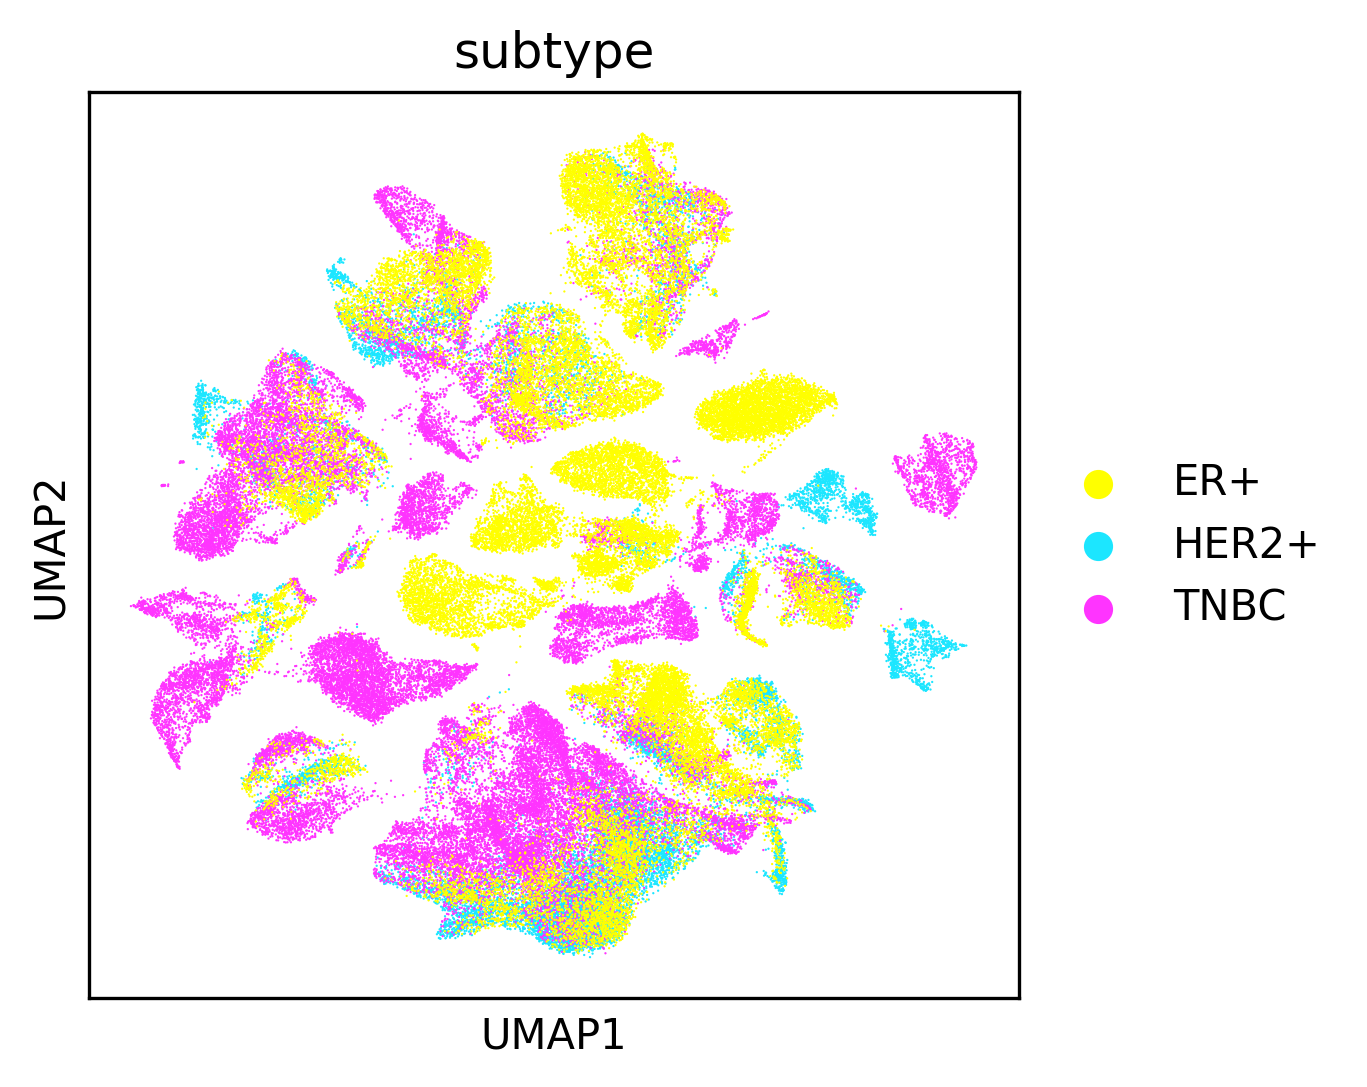

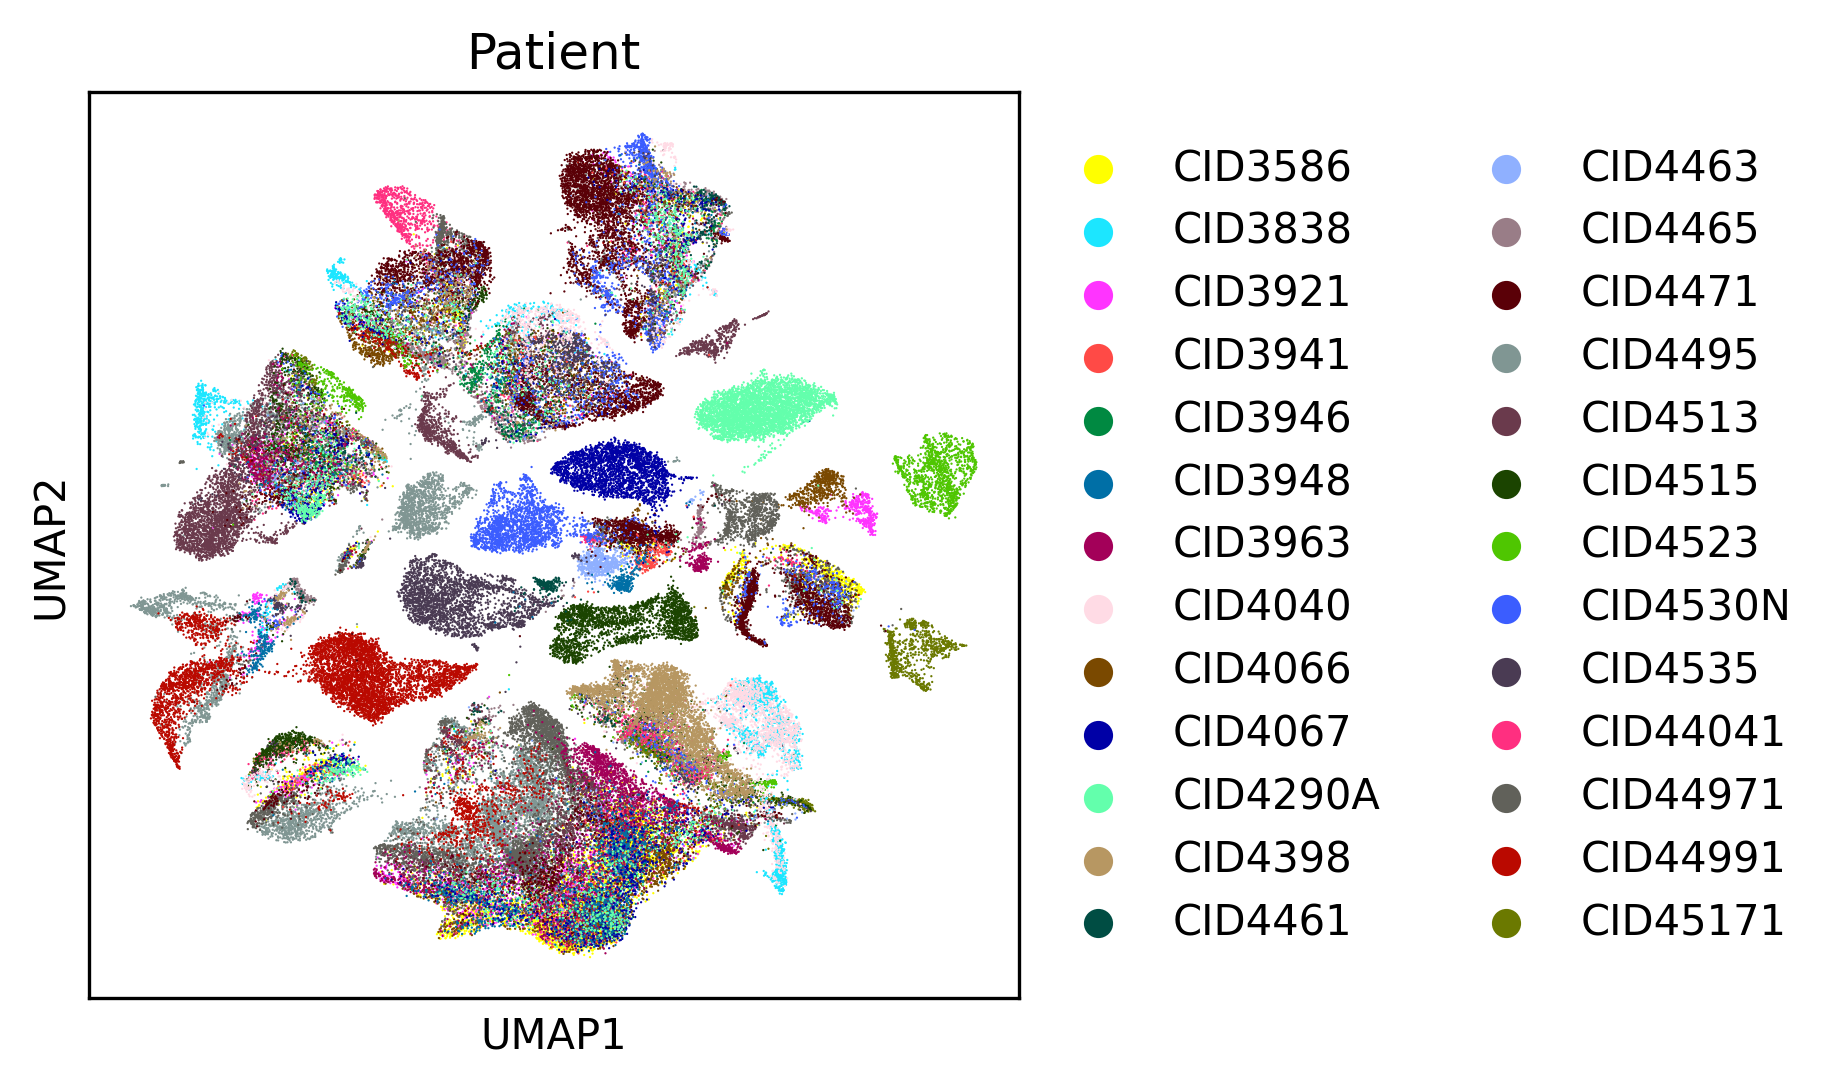

In [16]:
with plt.rc_context({'figure.figsize': (4, 4), 'figure.dpi': 300}):
    sc.pl.umap(adata, color=['leiden'], palette=sc.pl.palettes.godsnot_102, return_fig = True)  
    sc.pl.umap(adata, color=['celltype_major'], palette=sc.pl.palettes.godsnot_102, return_fig = True)  
    sc.pl.umap(adata, color=['celltype_minor'], palette=sc.pl.palettes.godsnot_102, return_fig = True)  
    sc.pl.umap(adata, color=['subtype'], palette=sc.pl.palettes.godsnot_102, return_fig = True)  
    sc.pl.umap(adata, color=['Patient'], palette=sc.pl.palettes.godsnot_102, return_fig = True)  



We already have the dataset annotated by the authors, so we are only makinh sure that the preprocessing was done correctly with the aggrement of the cluster to the annotated cell types.